# Quality Control

## Introduction

AnnData 개체를 생생한 후 raw read의 초기 처리 과정 중 감지되지 않은 낮은 퀄리티의 셀을 제거하기 위해 검사를 해야 합니다. 낮은 퀄리티의 셀을 제거하지 못하면 노이즈가 추가될 수 있습니다. scRNAseq를 수행하는 표준 방법은 없기 때문에 상황에 맞는 방법 선택과 값 선택이 중요합니다.

이전 노트북에서 준비한 데이터로 계속 작업할 것입니다. 사용하는 scanpy 함수들의 자세한 정보를 원하면 https://scanpy.readthedocs.io/en/stable/api.html 을 참고하세요.

In [4]:
import scanpy as sc 
import pandas as pd 
# qc metric 시각화하기 위해 matplotlib를 import합니다
import matplotlib.pyplot as plt 

%matplotlib inline 

adata = sc.read('./data/brain_raw.h5ad')

## Computing QC metrics

QC metric을 계산한 다음 그에 맞게 세포와 유전자를 필터링합니다. compute_qc_metrics 함수는 두 개의 DataFrame을 반환합니다: 하나는 세포에 대한 quality control metric을 포함하고 다른 하나는 유전자에 대한 metric입니다. 

In [5]:
# (cell_qc_dataframe, gene_qc_dataframe) tuple을 반환
# 제어하려는 변수를 ERCC로 설정
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])
                                                        
cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('세포에 대한 quality control metric:')
print(cell_qc_dataframe.head(3))

print('\n유전자에 대한 quality control metric:')
print(gene_qc_dataframe.head(3))

세포에 대한 quality control metric:
                         n_genes_by_counts  log1p_n_genes_by_counts  \
cell                                                                  
A1.B003290.3_38_F.1.1                 3359                 8.119696   
A1.B003728.3_56_F.1.1                 1718                 7.449498   
A1.MAA000560.3_10_M.1.1               3910                 8.271548   

                         total_counts  log1p_total_counts  \
cell                                                        
A1.B003290.3_38_F.1.1        390075.0           12.874097   
A1.B003728.3_56_F.1.1        776439.0           13.562474   
A1.MAA000560.3_10_M.1.1     1616087.0           14.295519   

                         pct_counts_in_top_50_genes  \
cell                                                  
A1.B003290.3_38_F.1.1                     25.884766   
A1.B003728.3_56_F.1.1                     43.051933   
A1.MAA000560.3_10_M.1.1                   44.066006   

                         pct_co

## QC for cells

### Library size

Read가 적은 세포는 손상되었거나 세포 캡처에 실패했을 가능성이 높으므로 제거를 하는 게 좋습니다.

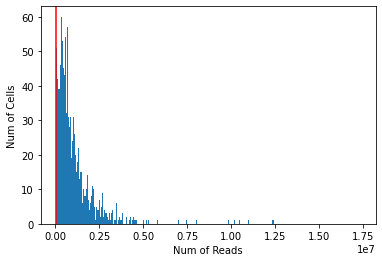

In [6]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Num of Reads')
plt.ylabel('Num of Cells')
# 50000개 미만의 read가 있는 세포들을 보기 위해 선을 긋습니다 (빨간색 선)
plt.axvline(50000, color='red')
# plt.xlim(0,1e6)

결과를 통해 이미 read의 수가 50,000개 미만인 세포는 제거된 걸 볼 수 있습니다.

### Detected Genes

Read가 transcriptome 전체에 잘 분산됬는지 확인해야합니다. 이것을 위해 각 샘플에서 감지한 고유한 유전자의 총 수를 계산합니다.

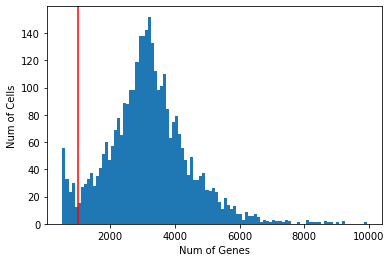

In [7]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('Num of Genes')
plt.ylabel('Num of Cells')
plt.axvline(1000, color='red')

### Spike-ins (ERCC)

세포 품질의 또 다른 측정 방법은 spike-in RNA와 endogenous RNA 간의 비율을 보는 것입니다. 높은 비율의 spike-in RNA가 있는 세포는 RNA의 양이 적은 편인데, 이는 세포가 죽거나 스트레스를 받아 RNA degration이 일어날 수 있기 때문입니다.

한번 ERCC의 비율이 10%인 지점에 선을 그어보겠습니다. Threshold를 설정할 때는 항상 상황에 따른 판단을 잘 해야 합니다.

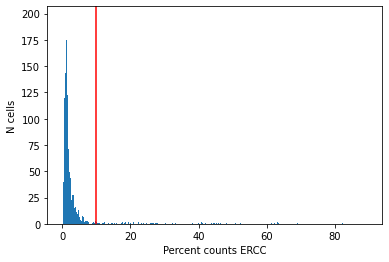

In [8]:
plt.hist(cell_qc_dataframe['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')

plt.axvline(10, color='red')

결과를 보면 대부분의 세포의 spike-in 비율이 10% 이하라는 것을 볼 수 있습니다. 10% 이상 구간에 세포들이 소량씩 조금 있는 걸 볼 수 있는데 이들은 죽은 세포일 가능성이 있으므로 제거해야 합니다.

## Cell Filtering

이제 결과를 기반으로 cell filtering을 할 차례입니다. 

In [9]:
# ERCC read의 비율이 10%보다 높은 세포들을 제거합니다
print('Start: \n', adata)
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]
print('\n\nAfter spike-in filtering: \n', adata)

# 1000개 미만의 유전자가 검출된 세포를 필터링합니다
sc.pp.filter_cells(adata, min_genes = 1000)
print('\n\nAfter gene count filtering: \n', adata)

Start: 
 AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'


After spike-in filtering: 
 View of AnnData object with n_obs × n_vars = 3218 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'


/Users/eujin/.conda/envs/scRNAnotebook/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number




After gene count filtering: 
 AnnData object with n_obs × n_vars = 3191 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


## QC for genes

발현 수준이 "detectable" 하다고 간주되는 유전자만 남기는 것이 좋습니다. 2개 이상의 세포에 해당 유전자로부터 5개 이상의 read가 포함된 경우 "detectable" 하다고 할 수 있습니다. 특정 유전자들은 퀄리티가 낮은 세포에서만 검출될 수도 있기 때문에 세포 QC를 진행한 후에 유전자 QC를 진행해야 합니다. 

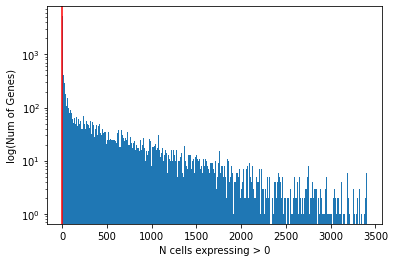

In [10]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(Num of Genes)')
# 최소 2개의 세포가 read를 포함 
plt.axvline(2, color='red')
# y축 스케일을 log로 설정
plt.yscale('log') 

* Tip: 실제로 코딩을 할 때는 각 그래프 전에 "a = plt.figure("graph name")"으로 그래프 이름을 설정해 주고 마지막 그래프 이후에 "plt.show()"를 적으면 모든 그래프를 동시에 볼 수 있습니다. 

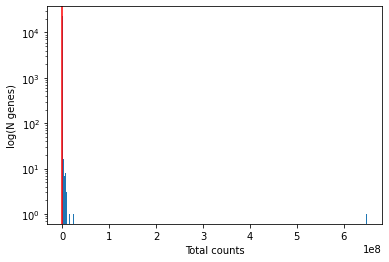

In [11]:
plt.hist(gene_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') 
plt.yscale('log') 
# 해당 유전자로부터 10개 이상의 read가 포함된 경우
plt.axvline(10, color='red')

## Gene Filtering

이제 결과를 기반으로 gene filtering을 할 차례입니다.

In [12]:
print('Start: \n', adata)
# 최소 2개의 세포에 read가 포함되는 경우
sc.pp.filter_genes(adata, min_cells = 2)
print('\n\nAfter filtering num of cells containing reads: \n', adata)
# 10개 이상의 read가 포함된 경우
sc.pp.filter_genes(adata, min_counts = 10)
print('\n\nAfter filtering number of reads from the gene: \n', adata)

Start: 
 AnnData object with n_obs × n_vars = 3191 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


After filtering num of cells containing reads: 
 AnnData object with n_obs × n_vars = 3191 × 19353
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells'


After filtering number of reads from the gene: 
 AnnData object with n_obs × n_vars = 3191 × 18583
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


이제 QC가 진행된 데이터 세트를 저장합니다.

In [13]:
adata.write('./data/brain_qc.h5ad')